In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import json

In [ ]:
from tensorflow.keras.applications import EfficientNetB3

model = EfficientNetB3(weights='imagenet')

Prediction: mushroom


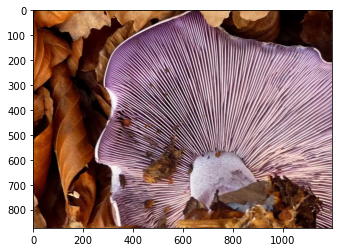

In [4]:
img_sample = './images_test/lepista_nuda/017cb8589e.jpg'

img = Image.open(img_sample)
image = img.resize((300, 300))
image = np.expand_dims(image, axis=0)

preprocess_input_mobilenet_v2 = tf.keras.applications.EfficientNetB3.preprocess_input

prediction = model.predict(image)

with open('imagenet-simple-labels.json') as f:
    labels = json.load(f)
    
prediction = labels[prediction.argmax()]

plt.figure()
_ = plt.imshow(img)

print(f'Prediction: {prediction}')

In [10]:
import tensorflow as tf

In [12]:
data_dir = './images_test/'
img_size = (300, 300)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size)

class_names = train_ds.class_names

Found 2567 files belonging to 7 classes.
Using 2054 files for training.
Found 2567 files belonging to 7 classes.
Using 513 files for validation.


In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)])

In [ ]:
checkpoint_path = './checkpoints/test_7class/
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1)

In [20]:
num_classes = len(class_names)

base_model = EfficientNetB3(weights='imagenet', include_top=False)

base_model.trainable = False

image_batch, label_batch = next(iter(train_ds))

feature_batch = base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(num_classes, 
                                         kernel_regularizer=tf.keras.regularizers.l2(0.001))

prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=(300, 300, 3))

x = data_augmentation(inputs)

x = base_model(x, training=False)

x = global_average_layer(x)

x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

Epoch 1/5
65/65 [==============================] - 398s 6s/step - loss: 1.2625 - accuracy: 0.6407 - val_loss: 0.7980 - val_accuracy: 0.8655
Epoch 2/5
65/65 [==============================] - 369s 6s/step - loss: 0.6267 - accuracy: 0.8759 - val_loss: 0.5293 - val_accuracy: 0.9240
Epoch 3/5
65/65 [==============================] - 371s 6s/step - loss: 0.4547 - accuracy: 0.9099 - val_loss: 0.4183 - val_accuracy: 0.9474
Epoch 4/5
65/65 [==============================] - 368s 6s/step - loss: 0.3848 - accuracy: 0.9275 - val_loss: 0.3641 - val_accuracy: 0.9435
Epoch 5/5
65/65 [==============================] - 371s 6s/step - loss: 0.3243 - accuracy: 0.9416 - val_loss: 0.3219 - val_accuracy: 0.9513


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'], 
              callbacks=[cp_callback])

In [ ]:
epochs = 5
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

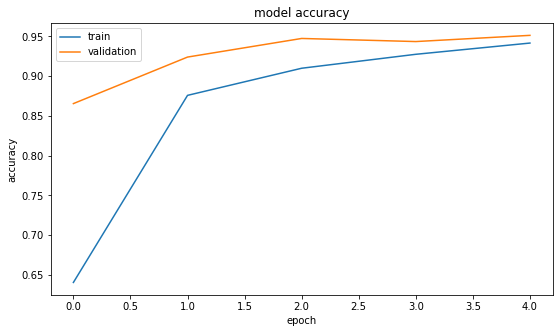

In [23]:
plt.figure(figsize=(9, 5))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.savefig(checkpoint_path+'history.jpg')

In [ ]:
confusion = tf.confusion_matrix(labels=y_, predictions=y, num_classes=num_classes)

In [38]:
image_batch, label_batch = next(iter(train_ds))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


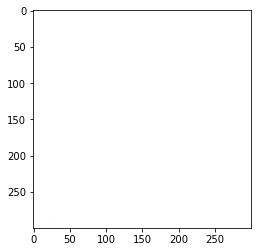

In [43]:
plt.figure()
plt.imshow(image_batch[0])

In [47]:
model.save_weights('./checkpoints/test_7class.h5')
# doesnt seem to work

In [67]:
model.save('./checkpoints/test_7class/my_model')

INFO:tensorflow:Assets written to: ./checkpoints/test_7class/my_model\assets


C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [185]:
loaded_model = tf.keras.models.load_model('./checkpoints/test_7class.h5')

In [179]:
train_images, train_labels = np.squeeze(list(train_ds.as_numpy_iterator())).transpose()

val_images, val_labels = np.squeeze(list(val_ds.as_numpy_iterator())).transpose()

C:\Users\danie\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [150]:
val_confusion = np.zeros((num_classes, num_classes))

for idx, val_img_batch in enumerate(val_images):
        
    val_prob_batch = model.predict(val_img_batch)
    
    val_pred_batch = np.argmax(val_prob_batch, axis=1)
    
    val_labels_batch = val_labels[idx]
    
    try:
        val_confusion += tf.math.confusion_matrix(labels=val_labels_batch, 
                                      predictions=val_pred_batch, 
                                      num_classes=num_classes)        
    except Exception as e:
        print(e)
    
#     if idx == 2:
#         break

In [184]:
train_confusion = np.zeros((num_classes, num_classes))

for idx, train_img_batch in enumerate(train_images):
        
    train_prob_batch = model.predict(train_img_batch)
    
    train_pred_batch = np.argmax(train_prob_batch, axis=1)
    
    train_labels_batch = train_labels[idx]
    
    try:
        train_confusion += tf.math.confusion_matrix(
                                    labels=train_labels_batch, 
                                      predictions=train_pred_batch, 
                                      num_classes=num_classes)        
    except Exception as e:
        print(e)
    
    if idx == 2:
        break

In [213]:
    def plot_confusion_matrix(confusion, save_file):
    
        conf_norm = [np.round(100*row/np.sum(row), 1) for idx, row in enumerate(confusion)]
        names = [class_name.replace('_', ' ').title() for class_name in class_names]


        plt.figure(figsize=(18, 10))
        _ = plt.imshow(conf_norm, cmap='YlOrBr', vmin=0, vmax=100)

        plt.ylabel('True label', size=18); plt.xlabel('Predicted label', size=18)

        plt.xticks(np.arange(num_classes), names, size = 14, rotation=90)
        plt.yticks(np.arange(num_classes), names, size = 14)

        for (j,i), label in np.ndenumerate(conf_norm):
            plt.text(i, j, str(label) + '%', ha='center', va='center', size=14)
        
        if save_file:
            plt.savefig(f'checkpoints/test_7class/{save_file}.jpg', bbox_inches='tight', dpi=100)
            plt.title(save_file.replace('_', ' ').title(), size=22);
            

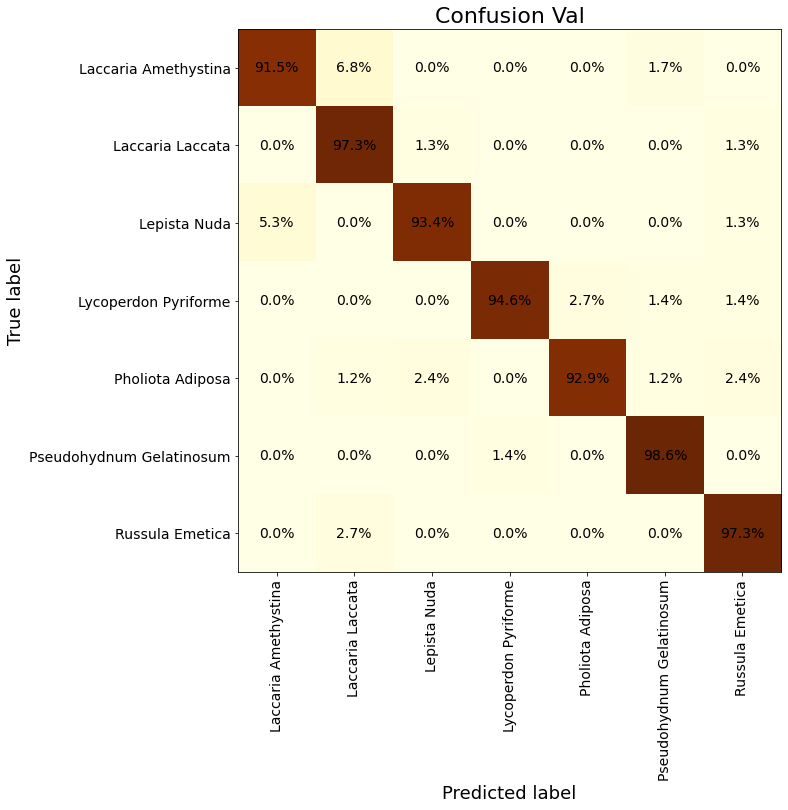

In [214]:
plot_confusion_matrix(confusion=train_confusion, save_file='confusion_train')

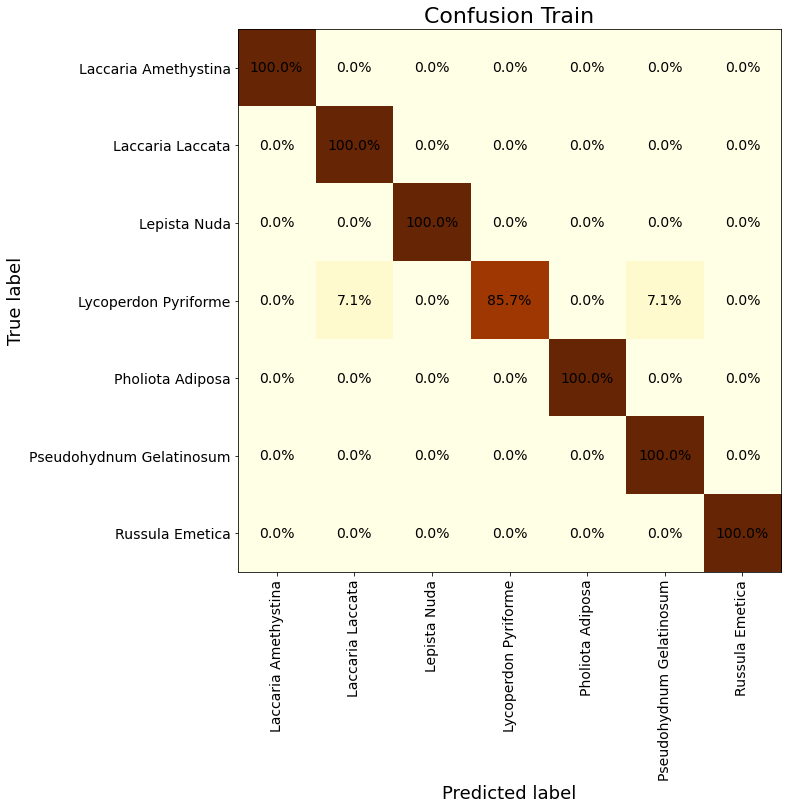

In [215]:
plot_confusion_matrix(confusion=val_confusion, save_file='confusion_val')

In [ ]:
# could use latest effnet:
# https://github.com/google/automl/blob/master/efficientnetv2/tutorial.ipynb